In [13]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Building The Model

After all of this messy cleaning, scraping, and joining, it was finally time for the fun part: building a machine learning model that attempted to predict rental prices for our Craigslist listings. We started by importing the grand dataframe, dropping all of the null values, and forming a rent price per square foot variable to include in our analysis.

In [2]:
df=gpd.read_file('/Users/michaelrosen/Desktop/Housing_Modeling/Data/Grand_Gdf.geojson')

In [3]:
df=df.dropna()

In [4]:
df['$persqft']=df['avg price']/df['avg sqft']

To get an initial sense of the spatial nature of our data, we mapped census tracts by their price per square foot rent prices and the number of permits in each census tract.

In [5]:
df_mercator = df.to_crs(epsg=3857)

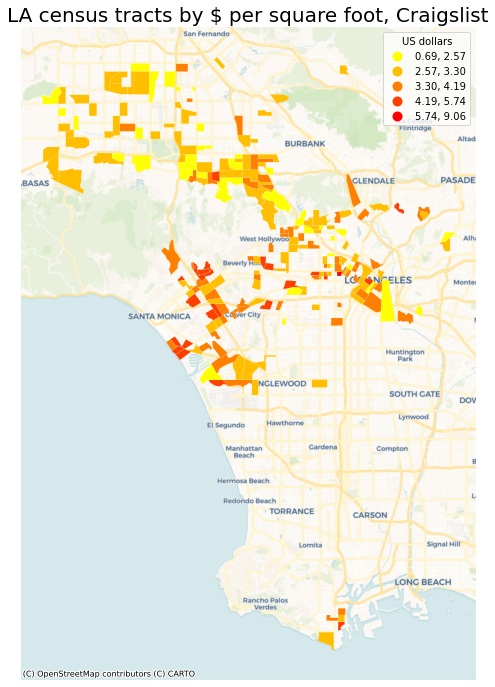

In [6]:
fig, ax = plt.subplots(figsize=(12, 12))
df_mercator.plot(column='$persqft', 
            cmap='autumn_r', 
            scheme='naturalbreaks',
            edgecolor='white', 
            linewidth=0.1, 
            ax=ax,
            legend=(True),
           )
ax.axis("off")
ax.set_title("LA census tracts by $ per square foot, Craigslist",fontsize=20)
ax.get_legend().set_title("US dollars")
ctx.add_basemap(ax, crs=df_mercator.crs.to_string(), source=ctx.providers.CartoDB.Voyager)

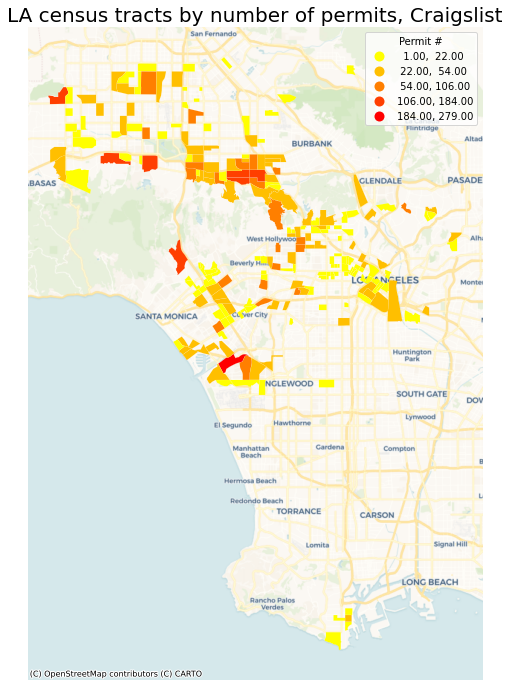

In [7]:
fig, ax = plt.subplots(figsize=(12, 12))
df_mercator.plot(column='permit_count', 
            cmap='autumn_r', 
            scheme='naturalbreaks',
            edgecolor='white', 
            linewidth=0.1, 
            ax=ax,
            legend=(True),
           )
ax.axis("off")
ax.set_title("LA census tracts by number of permits, Craigslist",fontsize=20)
ax.get_legend().set_title("Permit #")
ctx.add_basemap(ax, crs=df_mercator.crs.to_string(), source=ctx.providers.CartoDB.Voyager)

Judging solely by the eye test, it appeared that was some evidence for our hypothesis. Neighborhoods such as Westwood, Venice, and central Los Angeles had high rents and few permits; on the other hand, neighborhoods in the San Fernando Valley demonstrated the opposite pattern.

But we didn't want to conclude our analysis with an eye test. To start our modeling process, we ran a simple linear regression on our two variables of interest: building permit counts and the average rental price for each of our given census tracts.

In [8]:
a=df['permit_count']
e=df['avg price']
c=np.array(df['permit_count'])
d=np.array(df['avg price'])
m, b = np.polyfit(c, d, 1)

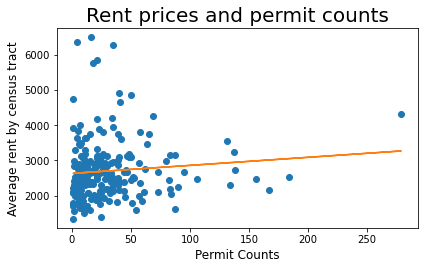

In [9]:
plt.plot(a,e,'o')
plt.plot(c, m*c + b)
plt.title(label="Rent prices and permit counts",
          fontsize=20,
          color="black",)
plt.xlabel('Permit Counts', fontsize=12)
plt.ylabel('Average rent by census tract', fontsize=12)
plt.tight_layout()
plt.subplots_adjust(top=0.85)

In [10]:
np.corrcoef(df['permit_count'], df['avg price'])

array([[1.        , 0.09466487],
       [0.09466487, 1.        ]])

We calculated a Pearson's correlation coefficient of 0.09, which indicated essentially no relationship between these two variables. We say this with some hestiation. For one, there are limitations to a linear model — a spatial autocorrelation or cluster analysis, for example, might tease out some stronger spatial relationships than may be evident on a simple plot. Additionally, we have the problem of relatively few observations and one strong outlier, which flattens the regression line significantly. (Without it, we can observe a slight negative relationship between permit counts and average rents.) Finally, the permit data was significantly right skewed, as the histogram below demonstrates. Because our permit data resists a normal distribution, it reduces its usefulness as a predictive variable.

<AxesSubplot:>

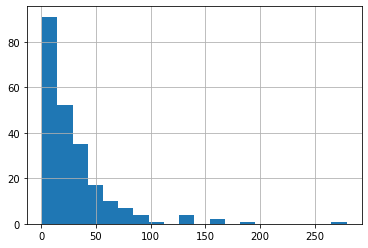

In [11]:
df['permit_count'].hist(bins=20)

With these limitations in mind, we set out to incorporate building permits into a broader machine learning model. We used the RandomForestRegressor to deal with our continuous variable, and included a slew of Census variables to pair with our building permits with the aim of increasing the predictive accuracy. We also created a new variable — high_ed — that combined percent of the census tract with a bachelor's degree, master's degree, and doctoral degree as a proxy for educational attainment.

In [15]:
df['high_ed']=df['PctBachelor']+df['PctMasters']+df['PctDoctorate']

In [16]:
xvars3 = ['permit_count', 'high_ed','PctNHW','PctBlackAA','PctAsian','pctPOC','Median HHI']
yvar3 = 'med price'
X_train3, X_test3, y_train3, y_test3 = train_test_split(
    df[xvars3], df[yvar3], test_size = 0.25, random_state = 1)

In [17]:
rf3 = RandomForestRegressor(n_estimators = 50, random_state = 1)
rf3.fit(X_train3, y_train3)
y_pred3 = rf3.predict(X_test3)

In [18]:
np.abs(y_pred3-y_test3).sum()

30933.010000000002

In [19]:
a5=y_test3
e5=y_pred3
c5=np.array(y_test3)
d5=np.array(y_pred3)
m5, b5 = np.polyfit(c5, d5, 1)

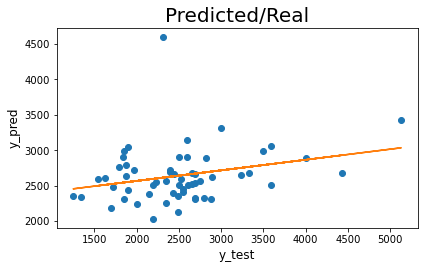

In [20]:
plt.plot(a5,e5,'o')
plt.plot(c5, m5*c5 + b5)
plt.title(label="Predicted/Real",
          fontsize=20,
          color="black",)
plt.xlabel('y_test', fontsize=12)
plt.ylabel('y_pred', fontsize=12)
plt.tight_layout()
plt.subplots_adjust(top=0.85)

In [22]:
np.corrcoef(y_test3,y_pred3)

array([[1.        , 0.27465783],
       [0.27465783, 1.        ]])

As the plot and the array above show, our machine learning model improved on the simple linear model's accuracy by a significant amount, producing a Pearson's correlation coefficient of 0.27. In plain English, this essentially conveyed to us that our chosen census variables and building permit information were somewhat successful in predicting the median Craigslist rental price in a given census tract.

That being said, there are some clear limitations to our initial dataframe. For one, we set the cutoff at five listings per census tract, which may or may not be a significant enough number of listings to justify a median rental price. To eliminate this concern, we filtered the dataframe to Census tracts with a minimum of 30 listings and re-ran our RandomForest model.

In [118]:
df_large_sample = df[(df['listing count'] >= 30)]

In [121]:
np.corrcoef(df_large_sample['$persqft'], df_large_sample['permit_count'])

array([[ 1.        , -0.12277551],
       [-0.12277551,  1.        ]])

(Interestingly, in this more statistically significant dataframe, a negative relationship was observed between price per square foot and permit count. In other words, the more permits in a given Census tract, the less the expected rent, which weakly supports our hypothesis.)

In [142]:
xvars4 = ['permit_count', 'high_ed','PctNHW','PctBlackAA','PctAsian','pctPOC','Median HHI']
yvar4 = 'med price'
X_train4, X_test4, y_train4, y_test4 = train_test_split(
    df_large_sample[xvars4], df_large_sample[yvar4], test_size = 0.4, random_state = 1)

In [143]:
rf4 = RandomForestRegressor(n_estimators = 50, random_state = 1)
rf4.fit(X_train4, y_train4)
y_pred4 = rf4.predict(X_test4)

In [144]:
a6=y_test4
e6=y_pred4
c6=np.array(y_test4)
d6=np.array(y_pred4)
m6, b6 = np.polyfit(c6, d6, 1)

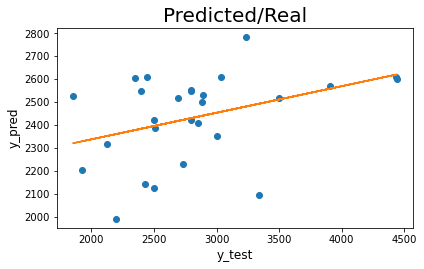

In [145]:
plt.plot(a6,e6,'o')
plt.plot(c6, m6*c6 + b6)
plt.title(label="Predicted/Real",
          fontsize=20,
          color="black",)
plt.xlabel('y_test', fontsize=12)
plt.ylabel('y_pred', fontsize=12)
plt.tight_layout()
plt.subplots_adjust(top=0.85)

In [147]:
np.corrcoef(y_test4,y_pred4)

array([[1.        , 0.38958372],
       [0.38958372, 1.        ]])

Here, we have some good news and bad news. On the good news side, we see our highest Pearson's correlation coefficient yet — the model with the larger samples delivers a 0.38 corrcoef. On the other hand, the plot shows that we have filtered our dataframe so many times that our overall number of observations is insufficent to draw any serious conclusions. 

To solve this issue, we reframed our predictive angle. Instead of attempting to predict the median rent price for a given census tract, we instead merged the listings dataframe with our census variables and the building permits with the goal of predicting the rent price for every single Craigslist listing.

In this new model, we used the Census variables and the building permit counts for the listing's Census tract to attempt to predict the price for that specific unit. This solved our observation size issue: instead of training our model on a couple dozen observations, we trained it on thousands.

In [23]:
df_model=pd.read_csv('/Users/michaelrosen/Desktop/Housing_Modeling/Data/JOINED_CENSUS_LISTINGS_MAY_27.csv')

In [24]:
colstokeep=['posted','post title','neighborhood','URL','price','latlon','y','x']

In [25]:
df_model=df_model[colstokeep]

In [26]:
gdf = gpd.GeoDataFrame(
    df_model, geometry=gpd.points_from_xy(df_model.x, df_model.y))

In [27]:
df2=gpd.read_file('/Users/michaelrosen/Desktop/Housing_Modeling/Data/Grand_Gdf.geojson')

In [28]:
model=gpd.sjoin(gdf.set_crs(epsg=4326),df2)

In [29]:
model=model.dropna()

In [30]:
model_test = model.drop_duplicates(subset = ["post title"])

In [31]:
model_test['high_ed']=model_test['PctBachelor']+model_test['PctMasters']+model_test['PctDoctorate']

/Users/michaelrosen/opt/anaconda3/envs/uds/lib/python3.8/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [32]:
model_test['price'] = model_test['price'].str.replace(',','')

In [33]:
model_test['price']= model_test['price'].apply(pd.to_numeric, errors='coerce')

After joining and some light cleaning, it was time to run the new and improved model.

In [38]:
xvars_ml = ['permit_count', 'high_ed','PctNHW','PctBlackAA','PctAsian','pctPOC','Median HHI']
yvar_ml = 'price'
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(
    model_test[xvars_ml], model_test[yvar_ml], test_size = 0.3, random_state = 1)

In [39]:
rf_ml = RandomForestRegressor(n_estimators = 50, random_state = 1)
rf_ml.fit(X_train_ml, y_train_ml)
y_pred_ml = rf_ml.predict(X_test_ml)

In [40]:
a_ml=y_test_ml
e_ml=y_pred_ml
c_ml=np.array(y_test_ml)
d_ml=np.array(y_pred_ml)
m_ml, b_ml = np.polyfit(c_ml, d_ml, 1)

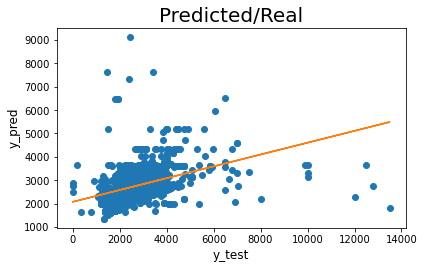

In [41]:
plt.plot(a_ml,e_ml,'o')
plt.plot(c_ml, m_ml*c_ml + b_ml)
plt.title(label="Predicted/Real",
          fontsize=20,
          color="black",)
plt.xlabel('y_test', fontsize=12)
plt.ylabel('y_pred', fontsize=12)
plt.tight_layout()
plt.subplots_adjust(top=0.85)

In [42]:
np.corrcoef(y_pred_ml,y_test_ml)

array([[1.        , 0.40420003],
       [0.40420003, 1.        ]])

Aha! This newfangled method for predicting the price of a given rental unit in our Craigslist dataframe produces our highest Pearson's correlation coefficient yet — and on a robust sample to boot. An additional benefit to this method is that we eliminate the concern of using census tracts with very few Craigslist listings.

After producing a satisfying model that appeared to have moderate strength in predicting the price of a Craigslist listing given socioeconomic characteristics and building permit issuances of a Census tract, we were naturally curious which features influenced the predictive power most strongly. The results were surprising.

Text(181.99293407059605, 0.5, 'Percent contribution')

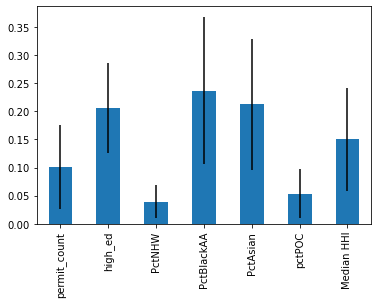

In [43]:
importances = rf_ml.feature_importances_
forest_importances_ml = pd.Series(importances, index=X_train_ml.columns)
std_ml = np.std([tree.feature_importances_ for tree in rf_ml.estimators_], axis=0)
fig_ml, ax_ml = plt.subplots()
forest_importances_ml.plot.bar(yerr=std_ml, ax=ax_ml)
ax.set_title("Feature importances of predictor variables")
ax.set_ylabel("Percent contribution")

The racial characteristics of the listing's Census tract were by far the most influential in influencing the predictive power of the model. While the error bars are large, it is undeniable that building permits — our original variable of concern — pales in comparison to these other variables.

# Conclusion

What can we take away from all of this? Ultimately, we did not find much evidence for our hypothesis. While the eye test revealed some potentially interesting patterns, subsequent linear regressions found a weak relationship at best between the number of building permits issued and the rental prices in a given census tract. When building permits were incorporated into a larger soup of predictive variables for our random forests machine learning model, it did not particularly distinguish itself relative to variables such as the percentage of Black residents or the average household income in the tract.

With all of that said, the fact that no statistical relationship was found may present some interesting avenues for analysis on its own. It is useful to entertain the counterfactual: in a city such as Seattle or Portland, where the city responded to its housing crisis with a densification strategy, would this relationship be different? Instead of seeing a weak negative relationship between building permits and rental prices, would it instead be a moderate or even strong negative relationship? 

Said another way, it is possible that the lack of a relationship between these two variables of concern in the city of Los Angeles does not tell us much about the predictive nature of building permits, but instead something about Los Angeles itself. There simply have not been that many permits issued in the city over the last 10 years, especially relative to the demand for such housing, and without these permits, it is near-impossible to tell if they'd make a difference. 